# Week 6 - Linear Regression

Learning contents:

1. Linear models
    - Polynomial function
    - Radial basis function
    - Sigmoidal basis function
    - Optimization of Error function
    - Test models
2. Bayesian Linear Regression 
    - Generate data
    - Fit the data
    - Predictive distribution

## Dependencies

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from scipy.stats import multivariate_normal

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

In [53]:
def target_func(x): return np.sin(2*np.pi*x)

def generate_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = target_func(x_train) + rng.normal(scale=0.1, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = target_func(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_data(10)

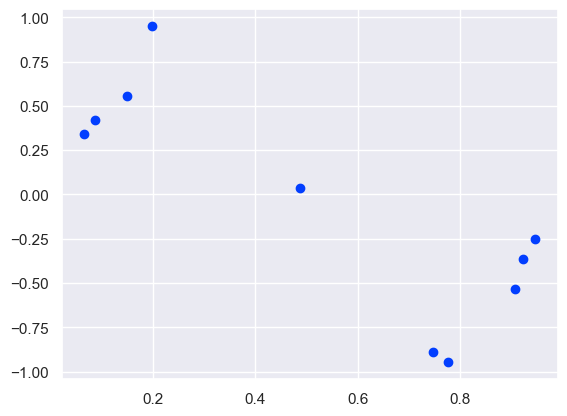

In [54]:
plt.scatter(x_train, y_train)

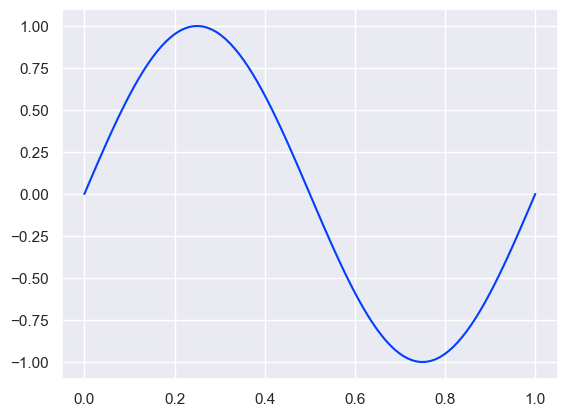

In [55]:
plt.plot(x_test, y_test, '-')

## 1) Linear models

Write down the function named linear that takes data point x (scalar), a basis function, and weights (list|ndarray (Mx1) and returns the output of linear basis function model (2nd equation in slide 5 of lecture 11, eq (3.3) in text book). The basis function (Phi(x)) that goes as input to linear will be defined later but it takes x (scalar) and i (index) and returns Phi_i(x) (which is a scalar).

In [56]:
def linear(x, basis, weights):
    phi = np.zeros(len(weights))
    phi[0] = 1
    for i in range(1, len(weights)):
        phi[i] = basis(x, i)
    return weights.T @ phi

### 1.1) Polynomial basis function

In `create_polynomial` below, write the code of `polynomial` function that takes data point `x` (scalar) and `i` (index) and returns the i-th value (scalar) of a polynomial basis function Phi_i(x) (see equation in slide 7 of lecture 11). As you can see, `create_polynomial` returns the resulting function (polynomial)! 

In [57]:
def create_polynomial():
    def polynomial(x, i):
        return x**i
    
    return polynomial

Plot the different polynomial basis functions for input x ranging from -1 to 1.

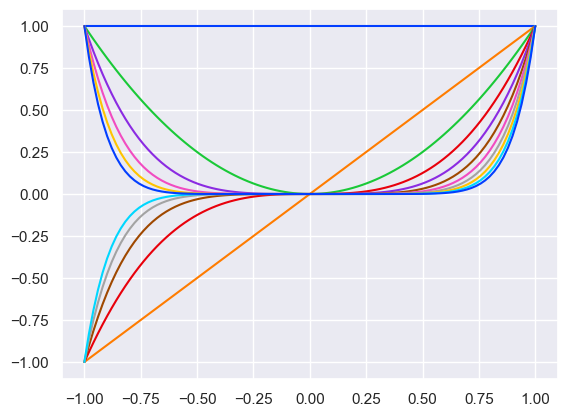

In [58]:
x = np.linspace(-1, 1, 100)
n = 11

polynomial = create_polynomial()

for i in range(n):
    y = list(map(lambda x: polynomial(x, i), x))
    plt.plot(x, y, '-')

### 1.2) Radial basis function

In the create_radial function below, you will implement the inner function radial. The inner function takes two inputs: a data point x (scalar) and an index i. It should return the scalar value of the i-th radial basis function, as defined in slide 8 of Lecture 11.

The outer create_radial function takes as input a vector means and a scalar variance.

The vector means defines the centers of all the radial basis functions.

By passing the index i, the inner radial function selects the i-th mean (means[i]) and uses it, together with the common variance, to compute the value of the radial basis function.

Thus, calling radial(x, i) evaluates the i-th basis function at the point x, and by looping over different indices i, you can generate all radial basis functions centered at the values in means.

In [59]:
def create_radial(means, variance):
    def radial(x, i):
        return exp(-(x - means[i])**2 / (2 * variance))
    
    return radial

The code below demonstrates how to generate and plot multiple radial basis functions.

np.linspace(-1, 1, 100) creates the data points, x, where the functions will be evaluated.

np.linspace(-1, 1, 11) defines 11 equally spaced centers (means) for the radial basis functions.

create_radial constructs the inner function radial(x, i), which evaluates the i-th radial basis function at point 𝑥, using the corresponding mean and a fixed variance.

The loop over i calls radial(x, i) for each center and plots all 11 radial basis functions on the same figure.

This way you can see how each basis function is shaped and how they overlap across the interval [−1,1].

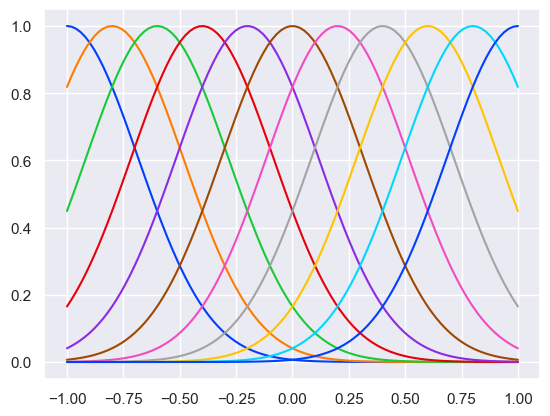

In [60]:
x = np.linspace(-1, 1, 100)
n = 11

radial = create_radial(np.linspace(-1, 1, 11), 0.1)

for i in range(n):
    y = list(map(lambda x: radial(x, i), x))
    plt.plot(x, y, '-')

### 1.3) Sigmoidal basis function

In the create_sigmoidal function below, you will implement the inner function sigmoidal.

The outer function takes as input a vector of means (means) and a slope parameter (s).

The inner function sigmoidal(x, i) takes a data point x (scalar) and an index i.

It then computes the i-th sigmoidal basis function at point x, using the i-th mean from the vector means and the slope parameter s (see definition in slide 9 of Lecture 11).

In [61]:
def create_sigmoidal(means, s):
    def sigmoidal(x, i):
        return (1 / (1 + exp(-(x - means[i]) / s)))
    
    return sigmoidal

Like previous case, by looping over different indices i, you can plot all sigmoidal basis functions centered at the values in means.

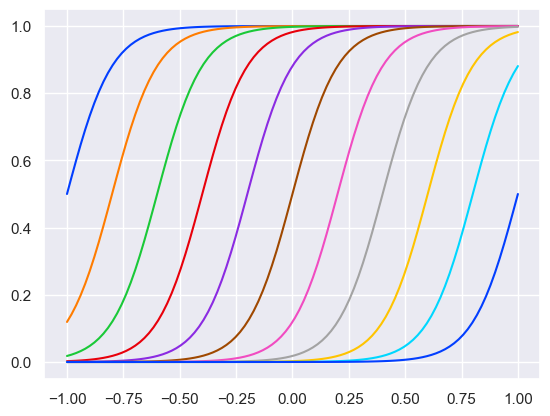

In [62]:
x = np.linspace(-1, 1, 100)
n = 11

sigmoidal = create_sigmoidal(np.linspace(-1, 1, 11), 0.1)

for i in range(n):
    y = list(map(lambda x: sigmoidal(x, i), x))
    plt.plot(x, y, '-')

### 1.4) Optimization of Error function

 
Write the `optimal_weights` function that computes the linear weights for fitting the given data with a chosen basis function (see the last equation on slide 11 of Lecture 11).  

**Details & conventions:**  
- `basis` is a function of the form `basis(x, i)` that evaluates the i-th basis function at scalar `x`.  
- We reserve **i = 0** for the bias term (phi_0(x) = 1).  
- For **i = 1 … M–1**, phi_i(x) = basis(x, i).  
- Construct the design matrix X with shape (N, M):  
  - Column 0 contains all ones (bias).  
  - Columns 1 … M–1 contain the basis function values evaluated at the training inputs.  
- Use this design matrix together with the target values to compute and return the weight vector `w`.  
- The result is a vector of length **M** (one bias + M–1 basis weights).  

**Inputs:**  
- `inputs`: list/1D array of training inputs of length N.  
- `targets`: list/1D array of training targets of length N.  
- `M`: total number of weights (1 bias + M–1 basis functions).  


In [63]:
def optimial_weights(basis, inputs, targets, M):
    N = len(inputs)
    Phi = np.zeros((N, M))
    
    for i in range(N):
        Phi[i, 0] = 1
        for j in range(1, M):
            Phi[i, j] = basis(inputs[i], j)
    
    w_ml = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ targets
    
    return w_ml

### 1.5) Test models

In [64]:
def test(basis, M, label=''):
    plt.plot(x_test, list(map(lambda x: linear(x, basis, optimial_weights(basis, x_train, y_train, M)), x_test)), '-', label=label)
    plt.plot(x_train, y_train, 'og')
    plt.legend()

The following code will test the performance of the optimal model using different basis function on input data generated at the start of the notebook. Which model you believe performs the best on this data? Does the model size affect the model performance?

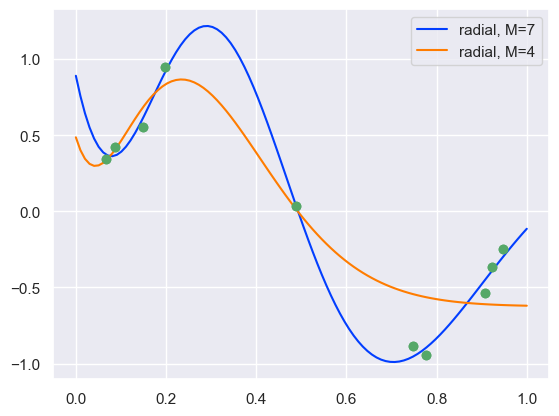

In [65]:
test(create_radial(np.linspace(-1, 1, 10), 0.1), 7, 'radial, M=7')
test(create_radial(np.linspace(-1, 1, 10), 0.1), 4, 'radial, M=4')

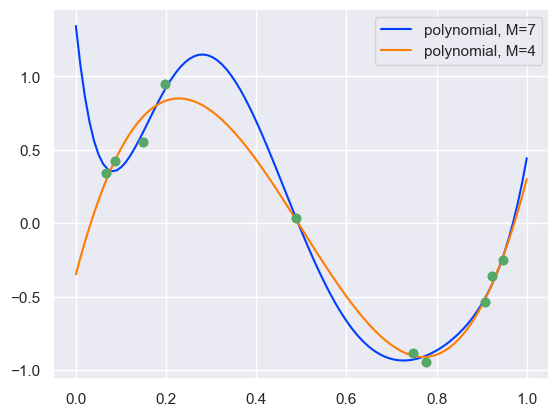

In [66]:
test(create_polynomial(), 7, 'polynomial, M=7')
test(create_polynomial(), 4, 'polynomial, M=4')

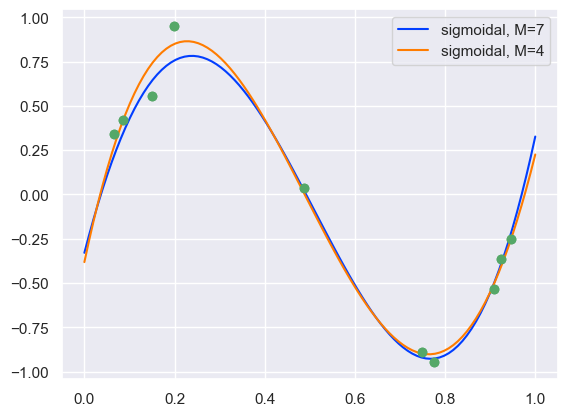

In [67]:
test(create_sigmoidal(np.linspace(0, 1, 8), 1), 7, 'sigmoidal, M=7')
test(create_sigmoidal(np.linspace(0, 1, 8), 1), 4, 'sigmoidal, M=4')

## 2) Bayesian Linear Regression 

### 2.1) Generate data

The following functions generate training and test data corresponding to a linear function. The data corresponds to a regression problem where individual input x and output y are both scalars.

In [68]:
def line_func(x): return -0.5 + 0.3 * x

def generate_line_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = line_func(x_train) + rng.normal(scale=0.05, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = line_func(x_test)
    
    return x_train, y_train, x_test, y_test

xl_train, yl_train, xl_test, yl_test = generate_line_data(25)

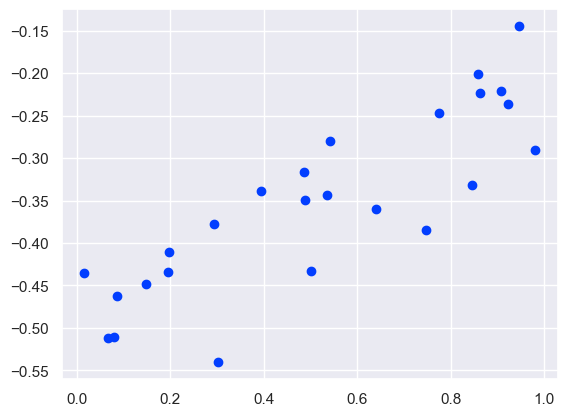

In [69]:
plt.scatter(xl_train, yl_train)

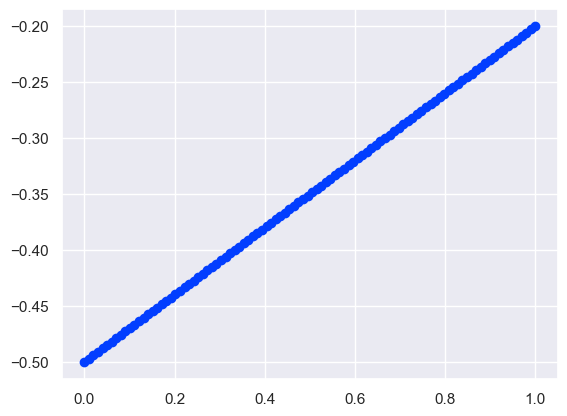

In [70]:
plt.scatter(xl_test, yl_test)

### 2.2) Fit the data


Implement `bayesian_regression_fit(PHI, t, alpha, beta)` to return the posterior
mean and covariance of the weight vector for Bayesian linear regression (see
slide 14 in Lecture 12).

Inputs:
- PHI: design matrix of shape (N, M), where M is the number of weights
  (including the bias term if present).
- t: targets, 1D array of length N (or shape (N, 1)).
- alpha: scalar prior precision for weights (zero-mean prior).
- beta: scalar noise precision (1/sigma^2).

Output:
- mean: ndarray of shape (M,) or (M,1) — posterior mean of the weights.
- covariance: ndarray of shape (M, M) — posterior covariance of the weights.

Notes:
- Use a zero-mean Gaussian prior with precision alpha * I_M.
- The posterior precision is alpha*I_M + beta * PHI.T @ PHI.
- Solve for the posterior mean using the targets and PHI.

In [71]:
def bayessian_regression_fit(PHI, t, alpha, beta):
    S0_inv = alpha * np.eye(PHI.shape[1])
    SN_inv = S0_inv + beta * PHI.T @ PHI
    SN = np.linalg.inv(SN_inv)
    mN = beta * SN @ PHI.T @ t
    return mN, SN

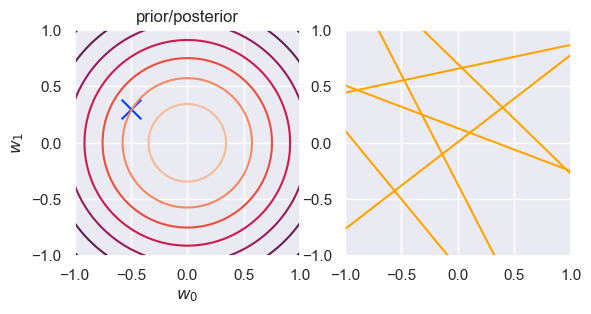

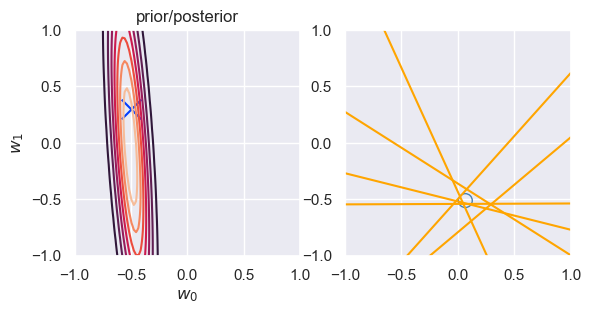

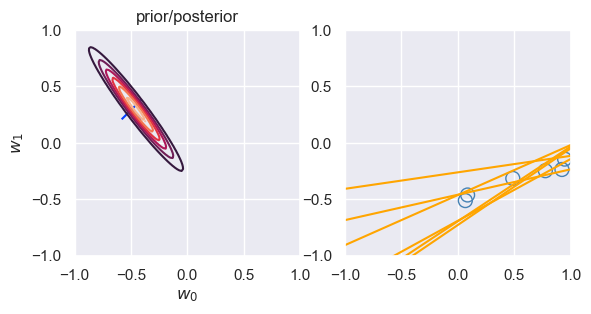

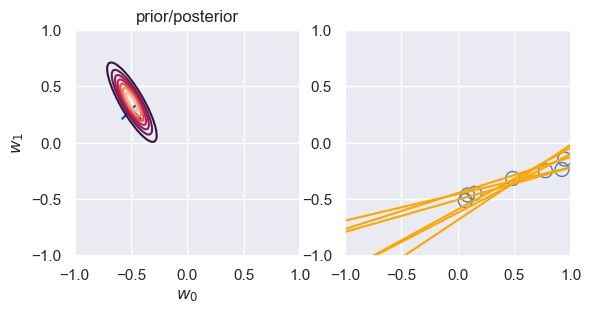

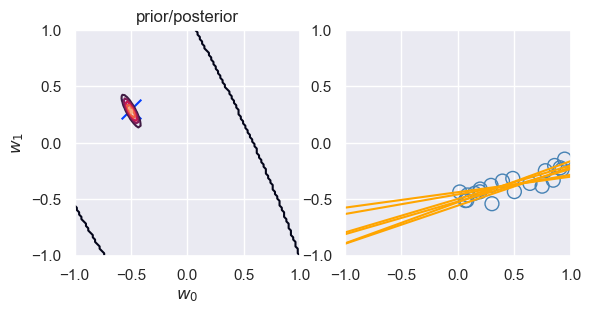

In [72]:
alpha = 1
beta = 100

x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100)
)
w = np.array([w0, w1]).transpose(1, 2, 0)

basis = create_polynomial()

M = 1

PHI = np.array([[basis(x[q], i) for q in range(len(x))] for i in range(M + 1)]).T
PHI_train = np.array([[basis(xl_train[q], i) for q in range(len(xl_train))] for i in range(M + 1)]).T

for begin, end in [[0, 0], [0, 1], [3, 6], [4, 7], [3, 20]]:
    
    w_mean, w_cov = bayessian_regression_fit(PHI_train[begin:end], yl_train[begin:end], alpha, beta)
    
    w_sample = np.random.multivariate_normal(
        w_mean.reshape(-1), w_cov, size=6
    )
    y_sample = PHI @ w_sample.T
    
    
    plt.subplot(1, 2, 1)
    plt.scatter(-0.5, 0.3, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=w_mean, cov=w_cov))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("prior/posterior")

    plt.subplot(1, 2, 2)
    plt.scatter(xl_train[:end], yl_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, y_sample, c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 2.3) Predictive distribution

Implement the sample(PHI_train, y_train, alpha, beta, PHI_test) function to compute the posterior predictive distribution for test points in Bayesian linear regression (see slide 16 in Lecture 12).

Inputs:

PHI_train: design matrix of shape (N, D) for the training set.

y_train: targets, array of length N (or shape (N, 1)).

alpha: scalar prior precision for the weights.

beta: scalar noise precision (1/σ²).

PHI_test: design matrix of shape (N_test, D) for the test set.

Outputs:

y: array of length N_test — predictive means at the test inputs.

y_std: array of length N_test — predictive standard deviations at the test inputs.

Notes:

First, call bayesian_regression_fit with the training data to obtain the posterior mean and covariance of the weights.

Compute the predictive mean as
y = PHI_test @ w_mean.

For each test row φ*, compute the predictive variance as
(1 / beta) + φ*^T @ w_cov @ φ*.

Return y_std as the square root of these predictive variances.

In [73]:
def sample(PHI_train, y_train, alpha, beta, PHI_test):
    w_mean, w_cov = bayessian_regression_fit(PHI_train, y_train, alpha, beta)
    
    y = PHI_test @ w_mean
    
    y_var = np.array([(1 / beta) + phi.T @ w_cov @ phi for phi in PHI_test])
    y_std = np.sqrt(y_var)
    return y, y_std

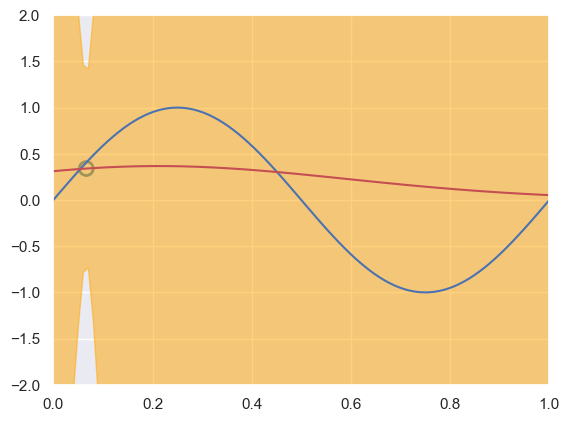

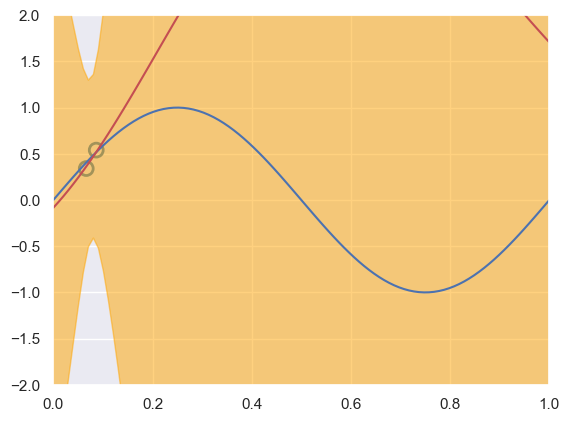

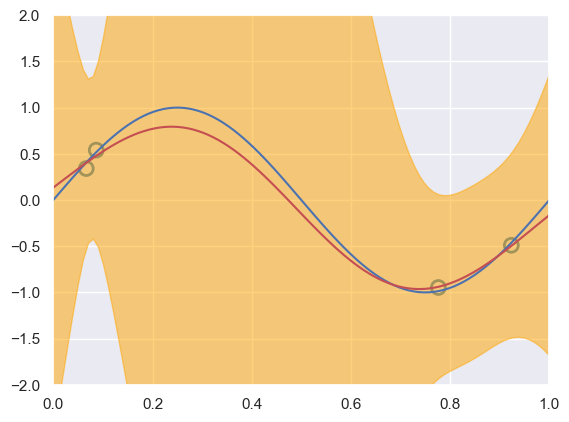

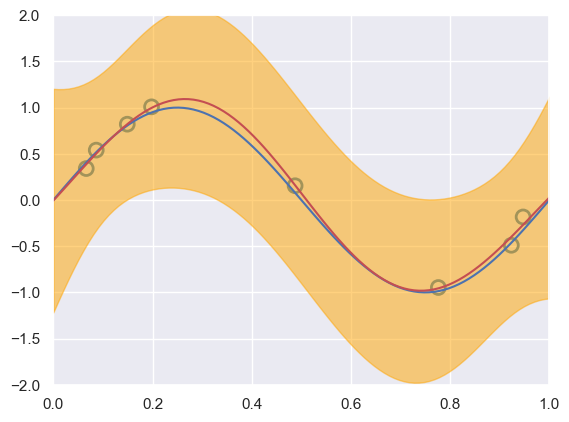

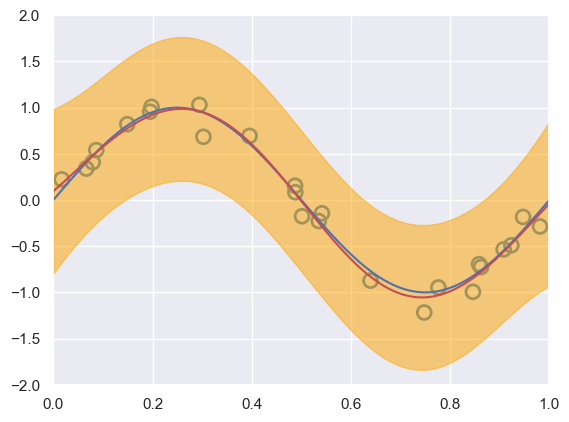

In [74]:
alpha = 1e-3
beta = 2
x_train, y_train, x_test, y_test = generate_data(25)

basis = create_radial(np.linspace(0, 1, 9), 0.1)

M = 8

PHI_train = np.array([[basis(x_train[q], i) for q in range(len(x_train))] for i in range(M + 1)]).T
PHI_test = np.array([[basis(x_test[q], i) for q in range(len(x_test))] for i in range(M + 1)]).T

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    
    y, y_std = sample(PHI_train[:end], y_train[:end], alpha, beta, PHI_test)
    
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2)
    plt.plot(x_test, y_test,'b')
    plt.plot(x_test, y,'r')
    plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()